## 1. Make classification data and get it ready

In [4]:
import sklearn

In [ ]:
from sklearn.datasets import make_circles

# Make 1000 samples
n_samples = 1000

# Create Circles
X, y = make_circles(n_samples, noise = 0.03, random_state=42)

In [ ]:
len(X), len(y)

In [ ]:
print(f"First 5 samples of X:\n {X[:5]}")
print(f"First 5 samples of y:\n {y[:5]}")

In [ ]:
# Make DataFrame of circle data
import pandas as pd
circles = pd.DataFrame({"X1": X[:,0],
                       "X2": X[:, 1],
                       "label": y})
circles.head(10)

In [ ]:
# Visualize
import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c = y,
            cmap = plt.cm.RdYlBu);

### 1.1 Check input and output shapes

In [ ]:
X.shape, y.shape

In [ ]:
X

In [ ]:
# View the first example of features and labels
X_sample = X[0]
y_sample = y[0]

print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")

### Turn data into tensors and create train and test splits

In [ ]:
import torch
torch.__version__

In [ ]:
type(X), X.dtype

In [ ]:
# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [ ]:
X[:5], y[:5]

In [ ]:
type(X), X.dtype, y.dtype

In [ ]:
# Split data into training and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.2, #0.2 = 20% of data will be test & 80% will be train
                                                    random_state=42)

In [ ]:
len(X_train), len(X_test), len(y_train), len(y_test)

In [ ]:
n_samples

## 2. Building a Model
Let's build a model to classify our blue and red dots.

To do so:
1. Setup Device agnoistic code so our code will run on an accelerator (GPU) if there is one.
2. Construct a model (by subclassing "nn.Module")
3. Define a loss function and optimizer
4. Create a training and test loop

In [ ]:
# Import PyTorch and nn
import torch
from torch import nn

# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

In [ ]:
X_train

1. Subclass nn.Module (Almost all models in PyTirch subclass nn.Module)
2. Create 2 nn.Linear() layers that are capable of handling the shapes of our data
3. Define a forward() method that outlines the forward pass (or forward computation) of the model
4. Instantiate an instance of our model class and send it to the target device

In [ ]:
y_train[:5]

In [ ]:
from sklearn import datasets
# Construct a model that subclass nn.Module
class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    #2. Create 2 nn.Linear Layers capable of handling the shapes of our data
    self.layer_1 = nn.Linear(in_features=2, out_features=5) #takes in 2 features and upscale it to 5 features
    self.layer_2 = nn.Linear(in_features=5, out_features=1) #takes in 5 features from previous layer and outputs a single feature (same shape as y)
  # 3. Define a forward() method that outlines the forward pass
  def forward(self, x):
   return self.layer_2(self.layer_1(x)) # x-> layer_1 -> layer_2 -> output

  ## 4. Instantiate an instance of our model class and send it to the target device
model_0 = CircleModelV0().to(device)
model_0

In [ ]:
device

In [ ]:
next(model_0.parameters()).device

In [ ]:
# Let's replicate the model above using nn.Sequential()
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=128),
    nn.Linear(in_features=128, out_features=1)
).to(device)

In [ ]:
model_0.state_dict()

In [ ]:
# Make Predictions
with torch.inference_mode():
  untrained_preds = model_0(X_test.to(device))
print(f"Length of Predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(X_test)}, Shape: {X_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 labels:\n{y_test[:10]}")

In [ ]:
X_test[:10], y_test[:10]

## 2.1 Setup loss function and optimizer

Whixh loss function and Optimizer should you use?

Again...this is problem specific.

For example for regression you might want MAE or MSE (mean absolute error or mean squared error)

For classification -> Binary Cross entropy or categorical cross entropy (Cross entropy)

As a reminder, the loss function measures how wrong the model predictions are


In [ ]:
## 2.1 Setup loss function and optimizer
loss_fn = nn.BCELoss() # BCELoss = requires inputs to have gone tbrough the sigmoid activation function prior ro input to BCELoss
nn.Sequential(
    nn.Sigmoid(),
    nn.BCELoss()
)
loss_fn = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss = sigmoid activation function (built-in)

optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

In [ ]:
model_0.state_dict()

In [ ]:
# Calculate accuracy - out of 100 examples, what percentage does our model get right?
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred)) * 100
  return acc

## 3. Train model

To train the model, we need to build a training loop:
1. Forward pass
2. Calculate the loss
3. Optimizer zero grad
4. Loss backward (backpropagation)
5. Optimizer step (gradient descent)

## 3.1 Going from raw logits -> prediction probabilities -> prediction labels
Our model outputs are going to be raw ***logits***

We can convert these ***logits*** into production probabilites by passing them to some kind of activation function (e.g. sigmoid for binary classification and softmax for multiclass classification)

Then we can convert our model's prediction probabilities to **prediction labels** by either rounding them or taking the 'argmax()'

In [ ]:
# View the first 5 outputs of the forwar pass on the test data
model_0.eval()
with torch.inference_mode():
  y_logits = model_0(X_test.to(device))[:5]
y_logits

In [ ]:
y_test[:5]

For our prediction probability values, we need to perform a range-style rounding on them:
* 'y_pred_probs' >= 0.5, 'y=1' (class=1)
* 'y_pred_probs' <= 0.5, 'y=0' (class 0)

In [ ]:
# Use the sigmoid activation function on our model logits to turn them into prediction probabilities
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

In [ ]:
# Find the predicted labels
y_preds = torch.round(y_pred_probs)

# In full (logits -> pred probs -> pred labels)
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

#Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dimension
y_preds.squeeze()

In [ ]:
y_test[:5]

Buildiing a training and testing loop

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
epochs = 1000

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test,  y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
  ### Training
  model_0.train()

  # 1. Forward pass
  y_logits = model_0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labels

  # 2. Calculate loss/accuracy
  # loss = loss_fn(torch.sigmoid(y_logits), #nn.BCELoss expects prediction probabilities as input
  #                y_train)
  loss = loss_fn(y_logits, #nn.BCEWithLogitsLoss expects raw logits as input
                 y_train)
  acc = accuracy_fn(y_true = y_train,
                    y_pred = y_pred)
  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss backward (backpropagation)
  loss.backward()

  # 5. Optimizer step (gradient descent)
  optimizer.step()

  ### Testing
  model_0.eval()
  with torch.inference_mode():
    # 1. Forward pass
    test_logits = model_0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    # 2. Calculate the test loss/acc
    test_loss = loss_fn(test_logits,
                        y_test)
    test_acc = accuracy_fn(y_true = y_test,
                        y_pred = test_pred)
    # Print out what's happenin'
    if epoch % 10 == 0:
      print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

In [ ]:
loss_fn

In [ ]:
loss_fn_without_logits = nn.BCELoss()
loss_fn_without_logits

### 4. Make predictions and evaluate the model

From the metrics it looks like our model isnt learning anything...

So to inspect it lets make some predictions and make them visual,

Import a function called 'plot_decison_boundary()'

In [ ]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if its not already downloaded)
if Path("helper_function.py").is_file():
  print("helper_function.py already exists, skipping download")
else:
  print("Download helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)
from helper_functions import plot_predictions, plot_decision_boundary

In [ ]:
# Plot decision boundary of the model
plt.figure(figsize = (12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

5. Improving a model (from a model perspective)
* Add more layers - give the model more chances to learn about patterns in the data
* Add more hidden units - go from 5 hidden to 10 hidden units
* Fit for longer
* Changing the activation functions
* Change the learning rates
* Change the loss function

These options are all from a model perspective because they deal directly with the model, rather than the data,
These are referred as ***hyperparameters***.

In [ ]:
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features = 2, out_features = 10)
    self.layer_2 = nn.Linear(in_features = 10, out_features = 10)
    self.layer_3 = nn.Linear(in_features = 10, out_features = 1)
  def forward(self, x):
    # z = self.layer_1(x)
    # z = self.layer_2(z)
    # z = self.layer_3(z)
    return self.layer_3(self.layer_2(self.layer_1(x)))

model_1 = CircleModelV1().to(device)
model_1

In [ ]:
# Create a loss function
loss_fn = nn.BCEWithLogitsLoss()

# Create an optimizer
optimizer = torch.optim.SGD(params = model_1.parameters(), lr = 0.1)

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
epochs = 1000

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test,  y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
  ### Training
  model_1.train()

  # 1. Forward pass
  y_logits = model_1(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labels

  # 2. Calculate loss/accuracy
  # loss = loss_fn(torch.sigmoid(y_logits), #nn.BCELoss expects prediction probabilities as input
  #                y_train)
  loss = loss_fn(y_logits, #nn.BCEWithLogitsLoss expects raw logits as input
                 y_train)
  acc = accuracy_fn(y_true = y_train,
                    y_pred = y_pred)
  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss backward (backpropagation)
  loss.backward()

  # 5. Optimizer step (gradient descent)
  optimizer.step()

  ### Testing
  model_1.eval()
  with torch.inference_mode():
    # 1. Forward pass
    test_logits = model_1(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    # 2. Calculate the test loss/acc
    test_loss = loss_fn(test_logits,
                        y_test)
    test_acc = accuracy_fn(y_true = y_test,
                        y_pred = test_pred)
    # Print out what's happenin'
    if epoch % 10 == 0:
      print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

In [ ]:
# Plot decision boundary of the model
plt.figure(figsize = (12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

### 5.1 Preparing data to see if our model can fit a straight line
One way to trouble shoot a larger problem is to test out on a smaller problem

In [ ]:
### Create some data (same as notebook 01)
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

# create data
X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias # Linear regression formula (without epsilon)

# check the data
print(len(X_regression))
X_regression[:5], y_regression[:5]

In [ ]:
# Create train and test splits
train_split = int(0.8 * len(X_regression))
X_train_regression, y_train_regression =  X_regression[:train_split],  y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]

# Check the lengths of each
len(X_train_regression), len(X_test_regression), len(y_train_regression), len(y_test_regression)

In [ ]:
plot_predictions(train_data = X_train_regression,
                 train_labels = y_train_regression,
                 test_data = X_test_regression,
                 test_labels = y_test_regression)

In [ ]:
X_train_regression[:10], y_train_regression[:10]

In [ ]:
model_1

In [ ]:
# Same architectures as model_1 (but using nn.Sequential())
model_2 = nn.Sequential(
    nn.Linear(in_features = 1, out_features = 10),
    nn.Linear(in_features = 10, out_features = 10),
    nn.Linear(in_features = 10, out_features = 1),
)

In [ ]:
model_2

In [ ]:
# Loss and optimizer
loss_fn = nn.L1Loss() # MAE loss with regression data
optimizer = torch.optim.SGD(params = model_2.parameters(),
                            lr = 0.01)

In [ ]:
# Train the model
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the numbver of epochs
epochs =1000

# Put the data on the target device
X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)

#Training
for epoch in range(epochs):
  y_pred = model_2(X_train_regression)
  loss = loss_fn(y_pred, y_train_regression)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  # Testing
  model_2.eval()
  with torch.inference_mode():
    test_pred = model_2(X_test_regression)
    test_loss = loss_fn(test_pred, y_test_regression)

  # Print out whats happening
  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f} | Test loss:{test_loss:.5f}")

In [ ]:
# Turn on evaluation mode
model_2.eval()

# Make predictions (inference)
with torch.inference_mode():
  y_preds = model_2(X_test_regression)

# Plot data and predictions
plot_predictions(train_data = X_train_regression,
                 train_labels = y_train_regression,
                 test_data = X_test_regression,
                 test_labels = y_test_regression,
                 predictions = y_preds);

## 6. The missing piece: non-linearity

"What patterns could you draw if you were given an infinite amount of a straight and non-straight lines?"

or in machine learning terms, an infinite (but reality it is finite) of linear and non-linear functions?

### 6.1 Recreating non-linear data (red and blue circles)

In [ ]:
# Make and plot data
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

plt.scatter(X[:, 0], X[:, 1], c = y, cmap =plt.cm.RdYlBu);

In [ ]:
# Convert data to tensors and then to train and test splits
import torch
from sklearn.model_selection import train_test_split

# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.2,
                                                    random_state = 42)

X_train[:5], y_train[:5]

### 6.2 Building a model with non-linearity
* Linear = straight linear
* Non-Linear = non-straight lines

Artificial neural networks are a large combination of linear (Straight) and (non-linear) functions which are potentially able to find patterns in data.

In [ ]:
from torch import nn
class CircleModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features = 10)
    self.layer_3 = nn.Linear(in_features=10, out_features = 1)
    self.relu = nn.ReLU() # relu is a non-linear activation functions?

  def forward(self, x):
    # Where should we put our non-linear activation functions?
    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_3 = CircleModelV2().to(device)
model_3

In [ ]:
# Setup loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(),
                            lr = 0.1)

In [ ]:
# spam or not spam
# credit cards = fraud or not fraud
# insurance claims = at fault or not fault

### 6.3 Training a model with non-linearity

In [ ]:
len(X_test), len(y_test)

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 1000

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  ## Training
  model_3.train()

  # 1. Forward pass
  y_logits = model_3(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels

  # 2. Calculate the loss
  loss = loss_fn(y_logits, y_train) # BCEWithlogitsLoss (takes in logits as first input)
  acc = accuracy_fn(y_true = y_train,
                    y_pred=y_pred)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss backward
  loss.backward()

  # 5. Step the optimizer
  optimizer.step()

  ### Testing
  model_3.eval()
  with torch.inference_mode():
    test_logits = model_3(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true = y_test,
                           y_pred = test_pred)
    ## Print out whats this happening
    if epoch % 100 == 0:
      print(f"Epoch: {epoch} | Loss: {loss:.4f}, Acc: {acc:.2f}% | Test loss: {test_loss:.4f}, Test acc: {test_acc:.2f}%")

## 6.4 Evaluating a model trained with non-linear activation function

In [ ]:
# Makes Predictions
model_3.eval()
with torch.inference_mode():
  y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()
y_preds[:10], y_test[:10]

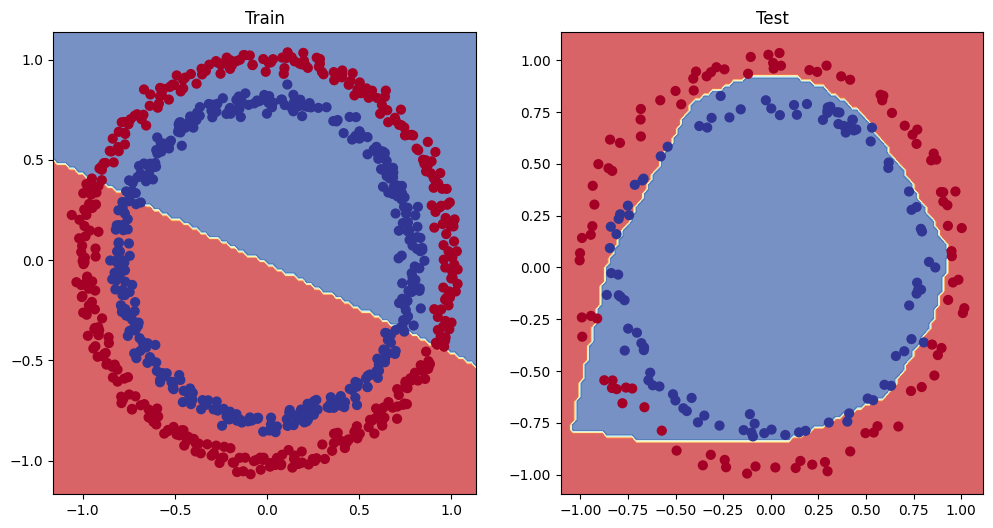

In [ ]:
# Plot decision boundaries
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train) # model_l = no non-linearity
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test) # model_3 = has non-linearity

# 7. Replicating non-linear activation functions
Neural networks, rather than telling us telling the model what to learn, we give it the tools to discover patterns in data and patterns on its own.

And these tools are linear & non-linear functions

In [ ]:
# Create a tensor
A = torch.arange(-10, 10, 1, dtype = torch.float32)
A.dtype

torch.float32

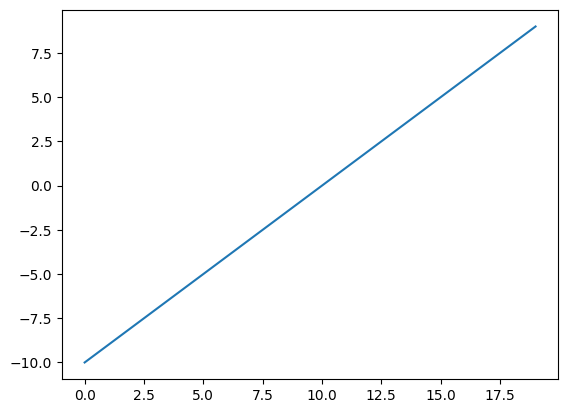

In [ ]:
# Visualize the tensor
plt.plot(A)

In [ ]:
def relu(x: torch.Tensor) -> torch.Tensor:
  return torch.maximum(torch.tensor(0), x) # inputs must be tensors

relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

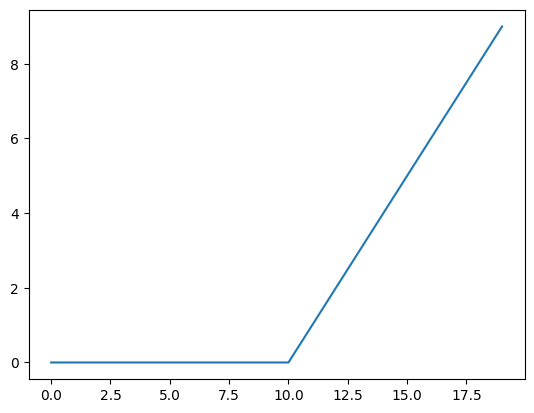

In [ ]:
plt.plot(torch.relu(A));

In [ ]:
# Now let's do the same for sigmoid
def sigmoid(x):
  return 1 / (1+torch.exp(-x))

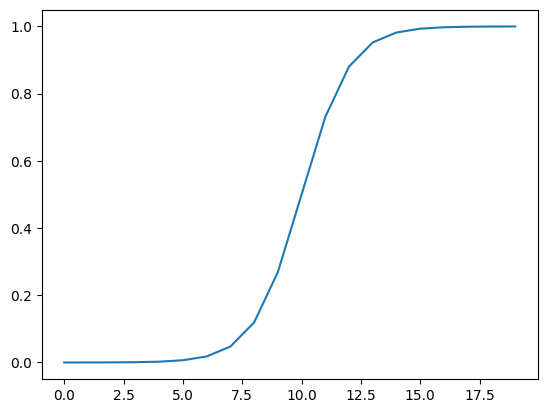

In [ ]:
plt.plot(torch.sigmoid(A))

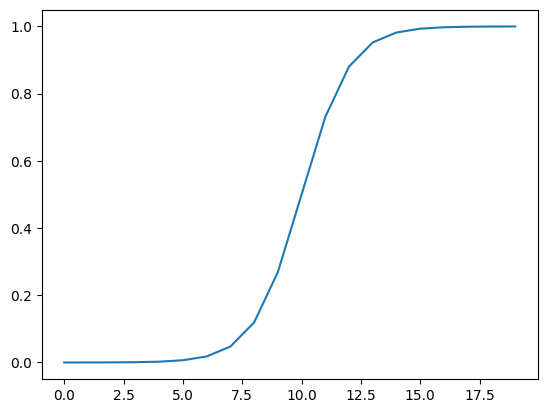

In [ ]:
plt.plot(sigmoid(A))

## 8. Putting it all together with a multi-class classification

Creating a toy multi-class dataset

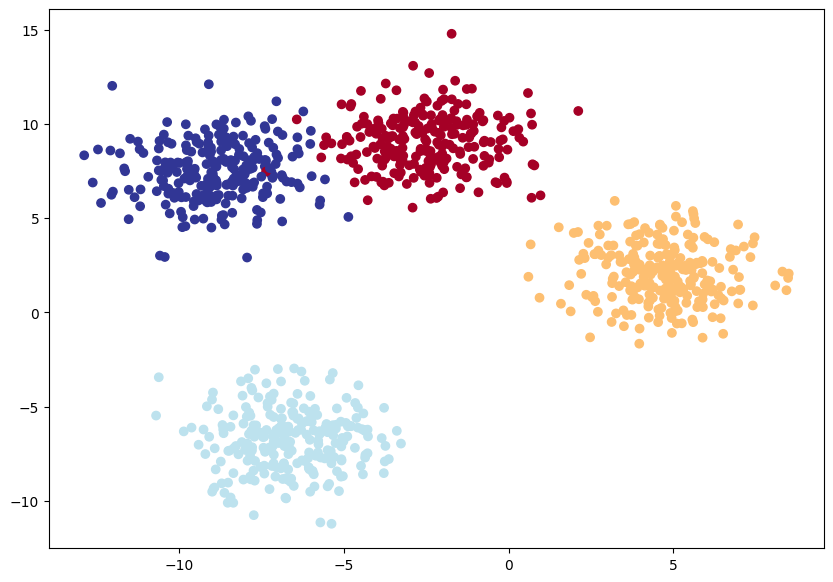

In [ ]:
# Import dependencies
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Set the hyperparameter for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples = 1000,
                            n_features = NUM_FEATURES,
                            centers = NUM_CLASSES,
                            cluster_std=1.5,
                            random_state = RANDOM_SEED)

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

# 3. Split into train and test
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
                                                                        y_blob,
                                                                        test_size = 0.2,
                                                                        random_state = RANDOM_SEED)

# 4. Plot data ()
plt.figure(figsize=(10,7))
plt.scatter(X_blob[:,0], X_blob[:, 1], c=y_blob, cmap =plt.cm.RdYlBu);

### 8.2 Building a multi-class classification model in PyTorch

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [ ]:
# Build a multi-class classification model
class BlobModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units = 8):
    """Initializes a multi-class classification model

    Args:
    input_features (int): Number of input features to the model
    output_features (int): Number of output features (number of output classes)
    hidden units (int): NUmber of hidden units between layers, default 8
    Returns:

    Example:
    """
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_features)
    )

  def forward(self, x):
      return self.linear_layer_stack(x)

# Create an instance of BlobModel and send it back to the target device
model_4 = BlobModel(input_features=2,
                    output_features=4,
                    hidden_units=8).to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [ ]:
X_blob_train.shape, y_blob_train[:10]

(torch.Size([800, 2]), tensor([1, 0, 2, 2, 0, 0, 0, 1, 3, 0]))

In [ ]:
torch.unique(y_blob_train)

tensor([0, 1, 2, 3])

### 8.3  Create a loss function and an optimizer for a multi-class classification model

In [ ]:
# Create a loss function for multi-class classification
loss_fn = nn.CrossEntropyLoss()

# Create an optimizer for multi-class classification
optimizer = torch.optim.SGD(params = model_4.parameters(),
                            lr=0.1)

### 8.4 Getting prediction probabilities for a multi-class PyTorch model

Logits (raw output of the model) -> Pred probs (use 'torch.softmax') -> Pred labels (take the argmax of the prediction probabilities)

In [ ]:
model_4.eval()
with torch.inference_mode():
  y_logits = model_4(X_blob_test.to(device))

y_logits[:10]

tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
        [-0.0973, -0.9431, -0.5963, -0.1371],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.4134, -0.5204, -0.9303, -0.6963],
        [-0.3118, -1.3736, -1.1991, -0.3834],
        [-0.1497, -1.0617, -0.7107, -0.1645],
        [ 0.1539, -0.2887,  0.1520, -0.0109],
        [-0.2154, -1.1795, -0.9300, -0.2745],
        [ 0.2443, -0.2472,  0.1649,  0.0061],
        [-0.2329, -1.2120, -0.9849, -0.3004]])

In [ ]:
# Convert our model's logit outputs to prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
        [-0.0973, -0.9431, -0.5963, -0.1371],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.4134, -0.5204, -0.9303, -0.6963],
        [-0.3118, -1.3736, -1.1991, -0.3834]])
tensor([[0.3169, 0.3244, 0.1405, 0.2182],
        [0.3336, 0.1432, 0.2026, 0.3206],
        [0.3011, 0.1843, 0.2823, 0.2323],
        [0.3078, 0.2766, 0.1836, 0.2320],
        [0.3719, 0.1286, 0.1532, 0.3463]])


In [ ]:
torch.sum(y_pred_probs[0])

tensor(1.0000)

In [ ]:
torch.max(y_pred_probs[0])

tensor(0.3244)

In [ ]:
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds

tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 3, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 1, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 3, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 1, 0, 1])

In [ ]:
torch.argmax(y_pred_probs[0])

tensor(1)

In [ ]:
y_blob_test

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0, 0, 1, 0, 0, 0, 3, 3, 2, 3, 3, 3, 0, 1, 2,
        2, 2, 3, 0, 1, 0, 3, 1, 1, 3, 1, 2, 1, 3, 0, 2, 0, 3, 3, 2, 0, 3, 1, 1,
        0, 3, 1, 0, 1, 1, 3, 2, 1, 1, 3, 2, 2, 0, 3, 2, 2, 0, 0, 3, 3, 0, 0, 3,
        3, 3, 2, 3, 3, 3, 3, 1, 0, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 1, 3, 3, 3,
        1, 0, 3, 2, 0, 0, 3, 0, 2, 3, 1, 0, 3, 2, 1, 1, 0, 2, 2, 3, 0, 0, 1, 2,
        2, 3, 0, 1, 2, 0, 0, 0, 2, 3, 1, 2, 3, 2, 0, 3, 0, 0, 1, 1, 1, 0, 2, 2,
        2, 2, 0, 3, 3, 2, 2, 1, 3, 2, 0, 0, 3, 3, 2, 1, 2, 0, 3, 2, 0, 3, 2, 0,
        2, 2, 2, 0, 3, 1, 1, 1, 1, 1, 3, 1, 0, 2, 2, 1, 2, 2, 0, 1, 2, 2, 0, 0,
        1, 3, 2, 0, 3, 1, 2, 1])

### 8.5 Creating a training loop and testing loop for a multi-class PyTorch model

In [ ]:
# Fit the multi-class model to the data
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
epochs = 100

# Put data to the target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
  ## Training
  model_4.train()

  # 1. Forward pass
  y_logits = model_4(X_blob_train)
  y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # logits -> prediction probabilities -> prediction labels

  # 2. Calculate the loss
  loss = loss_fn(y_logits, y_blob_train) # BCEWithlogitsLoss (takes in logits as first input)
  acc = accuracy_fn(y_true = y_blob_train,
                    y_pred=y_pred)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss backward
  loss.backward()

  # 5. Step the optimizer
  optimizer.step()

  ### Testing
  model_4.eval()
  with torch.inference_mode():
    test_logits = model_4(X_blob_test)
    test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)

    test_loss = loss_fn(test_logits, y_blob_test)
    test_acc = accuracy_fn(y_true = y_blob_test,
                           y_pred = test_pred)
    ## Print out whats this happening
    if epoch % 10 == 0:
      print(f"Epoch: {epoch} | Loss: {loss:.4f}, Acc: {acc:.2f}% | Test loss: {test_loss:.4f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 1.1588, Acc: 40.38% | Test loss: 1.0755, Test acc: 48.00%
Epoch: 10 | Loss: 0.6448, Acc: 96.75% | Test loss: 0.6607, Test acc: 97.50%
Epoch: 20 | Loss: 0.4254, Acc: 98.50% | Test loss: 0.4307, Test acc: 100.00%
Epoch: 30 | Loss: 0.2529, Acc: 99.12% | Test loss: 0.2451, Test acc: 99.50%
Epoch: 40 | Loss: 0.1123, Acc: 99.25% | Test loss: 0.1023, Test acc: 99.50%
Epoch: 50 | Loss: 0.0663, Acc: 99.25% | Test loss: 0.0585, Test acc: 99.50%
Epoch: 60 | Loss: 0.0507, Acc: 99.25% | Test loss: 0.0429, Test acc: 99.50%
Epoch: 70 | Loss: 0.0430, Acc: 99.25% | Test loss: 0.0349, Test acc: 99.50%
Epoch: 80 | Loss: 0.0384, Acc: 99.25% | Test loss: 0.0299, Test acc: 99.50%
Epoch: 90 | Loss: 0.0352, Acc: 99.25% | Test loss: 0.0266, Test acc: 99.50%


### 8.6 Making and evaluating predictions with a PyTorch multi-class model

In [ ]:
# Make predictions
model_4.eval()
with torch.inference_mode():
  y_logits = model_4(X_blob_test)

# View the first 10 predictions
y_logits[:10]

tensor([[-0.6249,  5.9860, -7.6323, -8.4470],
        [-2.1738, -6.3750, -3.7202,  3.1203],
        [-3.4102, -3.8958,  3.1567, -2.6119],
        [-1.1505,  4.1962, -3.8472, -4.8820],
        [ 3.7548, -1.3391, -9.1422, -6.9466],
        [-2.8211, -7.5767, -4.2944,  3.7944],
        [-3.0306, -3.3328,  2.7955, -2.1374],
        [ 3.3761, -4.0375, -6.8987, -3.5503],
        [-4.3620, -4.9904,  3.8123, -3.3814],
        [ 3.5012, -3.0281, -7.5401, -4.7064]])

In [ ]:
y_pred_probs = torch.softmax(y_logits, dim=1)
y_pred_probs[:10]

tensor([[1.3437e-03, 9.9865e-01, 1.2164e-06, 5.3854e-07],
        [4.9905e-03, 7.4740e-05, 1.0630e-03, 9.9387e-01],
        [1.3985e-03, 8.6060e-04, 9.9463e-01, 3.1073e-03],
        [4.7389e-03, 9.9483e-01, 3.1956e-04, 1.1353e-04],
        [9.9388e-01, 6.0966e-03, 2.4904e-06, 2.2378e-05],
        [1.3372e-03, 1.1504e-05, 3.0644e-04, 9.9834e-01],
        [2.9138e-03, 2.1537e-03, 9.8781e-01, 7.1181e-03],
        [9.9838e-01, 6.0198e-04, 3.4435e-05, 9.7989e-04],
        [2.8147e-04, 1.5016e-04, 9.9882e-01, 7.5044e-04],
        [9.9825e-01, 1.4575e-03, 1.5997e-05, 2.7210e-04]])

In [ ]:
y_blob_test

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0, 0, 1, 0, 0, 0, 3, 3, 2, 3, 3, 3, 0, 1, 2,
        2, 2, 3, 0, 1, 0, 3, 1, 1, 3, 1, 2, 1, 3, 0, 2, 0, 3, 3, 2, 0, 3, 1, 1,
        0, 3, 1, 0, 1, 1, 3, 2, 1, 1, 3, 2, 2, 0, 3, 2, 2, 0, 0, 3, 3, 0, 0, 3,
        3, 3, 2, 3, 3, 3, 3, 1, 0, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 1, 3, 3, 3,
        1, 0, 3, 2, 0, 0, 3, 0, 2, 3, 1, 0, 3, 2, 1, 1, 0, 2, 2, 3, 0, 0, 1, 2,
        2, 3, 0, 1, 2, 0, 0, 0, 2, 3, 1, 2, 3, 2, 0, 3, 0, 0, 1, 1, 1, 0, 2, 2,
        2, 2, 0, 3, 3, 2, 2, 1, 3, 2, 0, 0, 3, 3, 2, 1, 2, 0, 3, 2, 0, 3, 2, 0,
        2, 2, 2, 0, 3, 1, 1, 1, 1, 1, 3, 1, 0, 2, 2, 1, 2, 2, 0, 1, 2, 2, 0, 0,
        1, 3, 2, 0, 3, 1, 2, 1])

In [ ]:
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds[:10]

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])

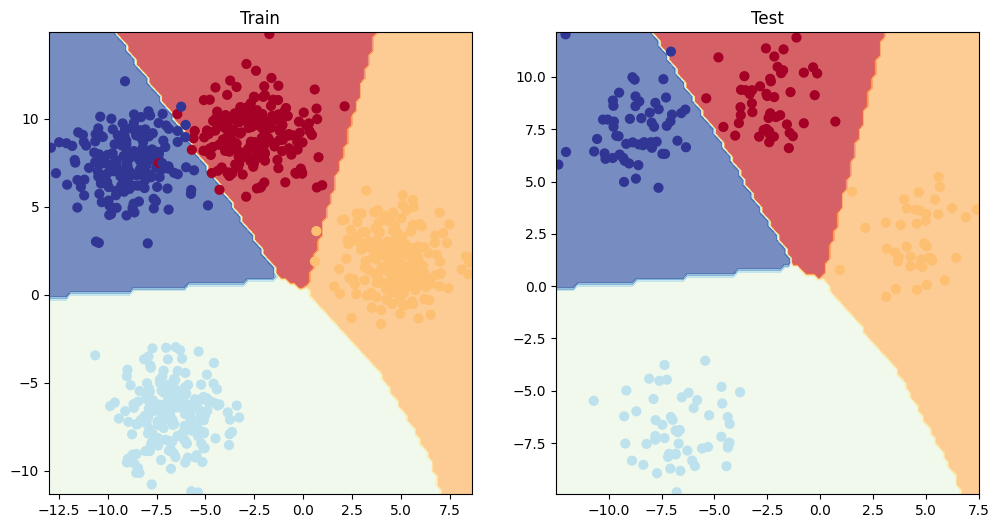

In [ ]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)

### 9. A few more classification metrics...(to evaluate our classification model)

* Accuracy - Out of 100 samples,how many does our model get right?
* Pecision -  
* Recall -
* F1 score
* Confusion matrix
* Classification report

https://towardsdatascience.com/beyond-accuracy-precision-and-recall-3da06bea9f6c

precision recall tradeoff
torchmetrics

In [ ]:
pip install torchmetrics

In [ ]:
from torchmetrics import Accuracy

# setup metric
torchmetric_accuracy = Accuracy().to(device)

#Calculate Accuracy
torchmetric_accuracy(y_preds, y_blob_test)